## 2. 강화학습 문제의 모형화

<div style="text-align: right"> <b>Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial issue : 2023.06.29 </div>
<div style="text-align: right"> last update : 2023.06.29 </div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 200
pd.options.display.max_rows = 100

### 2.2 one-armed bandit, 슬롯머신 문제

한 시행에서 에이전트는 n개의 슬로머신 중 하나를 선택해서 레버를 당긴다.   
한 시행에서 에이전트가 할수 있는 총 동작은 n가지이다.   
이러한 시행을 k번 반복한다.
k번째 시행의 액션 a로 부터 보상 $R_k$f를 받는다.

이 문제를 푸는 전략은 처음 몇번동안 서로 다른 레버를 당겨서 리워드를 관찰하는것이다.  
그 다음 관찰된 보상이 가장 큰 레버를 계속 당기는 것이다.   

이 전략을 위해서 이전 시행들에 기초한 특정 액션의 기대 보상, expected reward라는 개념이 필요하다. k번째 시행에서 액션 a의 기대 보상을 수식으로 $Q_k(a)$라고 표기한다.   
즉 기대 보상은 액션의 함수이며, 이 함수는 액션을 주어진 액션을 취했을 때 기대할 수있는 리워드의 양을 돌려준다.

In [2]:
def exp_reward(action, history):
    rewards_for_action = history[action]
    return sum(rewards_for_action) / len(rewards_for_action)

- 즉 k번째 시행에서 액션 a의 기대 보상은 그때까지 a의 모든 리워드의 산술 평균이다.   
- 따라서 이전 액션들과 관찰은 이후 액션에 영향을 미친다. 이를 이전 동작들이 현재 동작과 미래 동작들을 강화한다고 말할 수 있다.  
- $Q_k(a)$를 뭔가 가치를 말해준다는 점에서 동작 가치함수(action value function)라고 부른다.

기대 보상에 근거해서 최선의 동작을 찾는 코드

In [3]:
def get_best_action(actions):
    best_action = 0
    max_action_value = 0
    for i in range(len(actions)):
        cur_action_value = get_action_value(actions[i])
        if cur_action_value > max_action_value:
            best_action = i
            max_action_value = cur_action_value
            
    return best_action

- 위 방식을 사용하면 아직 시도한 적없는 어쩌면 기대 보상이 더 큰 레버를 선택하는 일은 없다. 
- 이처럼 지금까지의 경험에만 근거해 최선의 것을 선택하는 접근 방식을 greedy method라고 한다.

최선의 동작을 발견하려면 입실론 확률로 무작위 동작을 하고, 1- 입실론 확률로 탐욕법을 적용한다.

In [4]:
n = 10
probs = np.random.rand(n)
eps = 0.1

카지노 슬롯 머신이 10가정하자. 
위에서 n = 10으로 설정함.   

여기서는 랜덤변수를 구해서 그것이 슬롯 머신의 확률보다 작으면 리워드에 1을 더하는 과정을 반복한다.  

In [5]:
import random

def get_reward(prob, n = 10):
    reward = 0
    for i in range(n):
        if random.random() < prob:
            reward += 1
    return reward

예를 들어 슬롯 머신의 확률이 0.7이라고 하자.  
첫번째 루프에서 랜덤 변수가 0.4가 나왔다면 리워드 1을 더하는 방식이다.   

만약 리워드 받는 행위를 여러번 반복하면 평균 보상이 7에 가깝게 된다.

In [6]:
reward_test = [get_reward(0.7) for _ in range(2000)]
print(reward_test)

[7, 6, 6, 7, 8, 6, 8, 8, 9, 7, 8, 7, 6, 6, 4, 6, 8, 5, 4, 7, 7, 7, 9, 6, 6, 9, 4, 7, 6, 8, 8, 6, 8, 9, 4, 4, 4, 6, 6, 9, 5, 7, 6, 7, 8, 9, 7, 8, 6, 8, 3, 8, 8, 7, 8, 8, 9, 9, 7, 9, 7, 9, 6, 8, 8, 8, 6, 7, 7, 7, 6, 6, 7, 9, 6, 7, 6, 4, 8, 7, 7, 7, 6, 8, 8, 7, 7, 5, 6, 8, 7, 6, 8, 7, 7, 9, 7, 6, 8, 10, 9, 6, 5, 9, 8, 6, 3, 8, 7, 5, 8, 2, 8, 9, 10, 6, 8, 8, 6, 7, 7, 8, 9, 10, 8, 8, 8, 7, 6, 5, 7, 7, 9, 8, 6, 5, 7, 6, 6, 8, 3, 7, 7, 5, 6, 7, 6, 8, 8, 6, 9, 8, 6, 9, 4, 5, 7, 6, 9, 4, 6, 8, 9, 6, 7, 3, 6, 9, 7, 8, 6, 6, 9, 5, 7, 5, 9, 6, 9, 7, 8, 7, 7, 7, 5, 5, 7, 8, 6, 7, 8, 5, 7, 4, 6, 6, 3, 5, 5, 9, 8, 8, 7, 8, 4, 6, 6, 9, 8, 10, 7, 9, 7, 7, 5, 5, 9, 7, 6, 7, 7, 8, 7, 7, 9, 8, 5, 8, 5, 9, 6, 7, 6, 9, 9, 5, 8, 8, 6, 4, 8, 7, 6, 7, 9, 8, 7, 8, 9, 9, 9, 6, 5, 5, 8, 5, 9, 6, 8, 9, 9, 8, 7, 9, 7, 5, 7, 8, 8, 9, 7, 9, 6, 7, 9, 8, 6, 8, 8, 5, 6, 6, 8, 9, 9, 7, 8, 7, 8, 10, 6, 7, 6, 7, 4, 6, 6, 7, 7, 7, 7, 6, 8, 6, 6, 6, 5, 8, 8, 7, 7, 7, 7, 6, 6, 8, 7, 9, 7, 10, 6, 6, 7, 6, 8, 7, 5, 6, 7, 9, 10,

In [7]:
np.mean(reward_test)

7.007

(array([  1.,   4.,  15.,  70., 207., 397., 552., 441., 313.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 9 artists>)

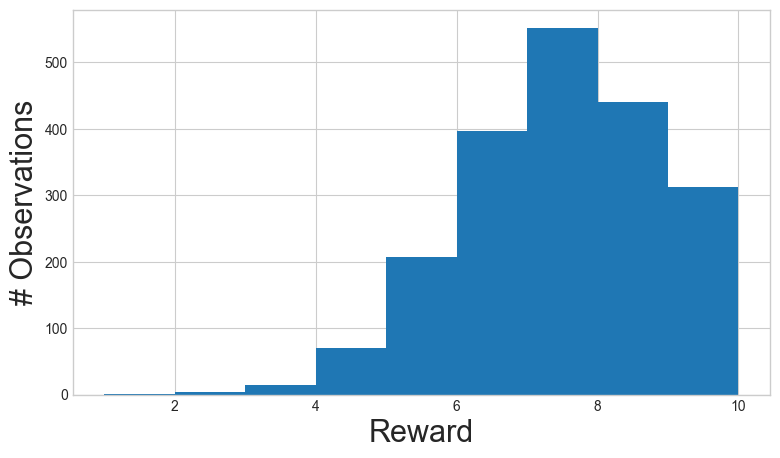

In [8]:
plt.figure(figsize=(9,5))
plt.xlabel("Reward",fontsize=22)
plt.ylabel("# Observations",fontsize=22)
plt.hist(reward_test,bins=9)

이제 greedy method를 구현해보자.  
이를 위해서는 어떤 레버를 담겼고 보상이 어떤지 기록해야함.  
가장 간단한 방법은 파이썬 리스트에 (레버 번호, 리워드) 형태의 튜플을 출가하는 것이다.  
예를 들어 (2, 9)는 2번 레버를 당겨서 9달러의 상금을 얻었음을 뜻함

그런데 위와 같은 방법은 시행을 여러번 할 수록 길어진다.   
간단하게 각 레버의 평균 리워드만 기억하면 된다.

In [9]:
sum = 0
x = [4, 5, 6, 7]

for j in range(len(x)):
    sum = sum + x[j]
    
sum

22

한 레버의 평균 보상을 구한 상태에서 그 레버를 다시 당겨서 새 리워드를 받았을 때 평균을 구하려면 간단하게 다음과 같이 구현하면 된다.  

새 평균 = (k*평균 + 리워드) /(k + 1)

이제 레버가 총 10개라고 하면 다음과 같은 배열을 준비하면 된다.

In [10]:
record = np.zeros((n, 2))
record

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]])

- 위에서 각 요소의 첫번째는 레버를 당긴 횟수이고, 두번째는 현재까지의 평균이다.  

이제 새 액션과 리워드로 이 배열을 갱신하는 함수를 살펴보자.

In [11]:
def update_record(record, action, r):
    new_r = (record[action, 0] * record[action, 1] + r) / (record[action, 0] + 1)
    record[action, 0] += 1
    record[action, 1] = new_r
    return record

In [12]:
def get_best_arm(record):
    arm_index = np.argmax(record[:, 1], axis = 0)
    return arm_index

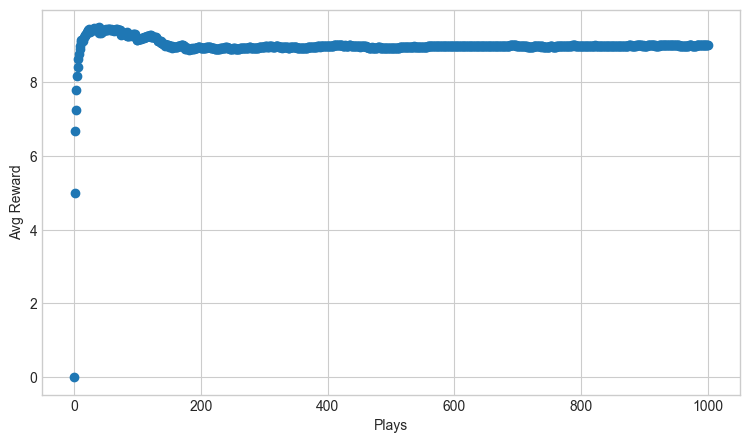

In [13]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9, 5)

record = np.zeros((n, 2))
probs = np.random.rand(n)

eps = 0.2
rewards  = [0]

for i in range(1000):
    if random.random() > eps:
        choice = get_best_arm(record)
    else:
        choice = np.random.randint(10)
        
    r = get_reward(probs[choice])
    record =  update_record(record, choice, r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)

ax.scatter(np.arange(len(rewards)),rewards)

소프트맥스 선택 정책 

다른 예를 살펴보자.    
심장마비 치료를 하는 의사가 있다.   
치료법은 10가지, 환자당 하나의 치료법만 적용가능하다.  
열가지 치료법의 효능과 위험도는 다르며 의사는 어떤 것이 최고인지 알지 못한다.   

앞의 슬롯머신 예와 비슷하지만 입실론 그리디 정책을 사용할 수 없다. 환자가 죽을 수도 있기 때문이다.  

이때는 소프트맥스 선택 정책이 적합하다.   
확률분포를 따져서 최악의 옵션을 피할 수 있다.

$$Pr(A) = e^{Q_{k}(A)/\tau}/sum(e^{Q_{k}(A)/\tau})$$

확률의 비례계수로 작용하는 매개변수 $\tau$를 temperature라고 한다.   
tempr가 높으면 확률들이 서로 비슷해지고, 낮으면 차이가 커진다.  
이 매개변수는 초기치를 선택한 후 시행착오를 거쳐 조율해 나가야 한다.

In [14]:
def softmax(av, tau = 1.12):
    softm = (np.exp(av / tau)/ np.sum(np.exp(av/ tau)))
    return softm

In [15]:
n

10

슬롯머신 문제에서 softmax를 적용한다면 get_best_arm 함수는 필요 없다.  
softmax가 모든 가능한 액션의 확률 분포를 리턴하므로 확률에 따라 무작위로 동작을 선액하면 된다.  
최선의 동작은 확률이 가장 높으므로 많이 선택 될 것이다.

해법 구현하는 방법을 알아보자.   
각 시행에서 해법은 softmax 함수를 record 배열의 제2열에 적용한다.  
각 항목의 둘째 수치가 action의 평균 보상이다.    

그다음에 numpy의 random.choice 함수를 사용해서 확률 분포에 따라 선택한다.   
최기에는 record 배열의 모든 항목이 0 이므로 softmax는 레버의 모든 선택확률이 동일한 균등 분포를 리턴한다.  
그러나 시간이 반복됨에 따라 보상이 클수록 확률이 높은 확률 분포를 리턴한다.

In [16]:
x = np.arange(10)
x

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [17]:
av = np.zeros(10)
av

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [18]:
p = softmax(av)
p

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [19]:
np.random.choice(x, p = p)

0

다음은 소프트맥스를 사용한 해법이다. (다시 볼것)

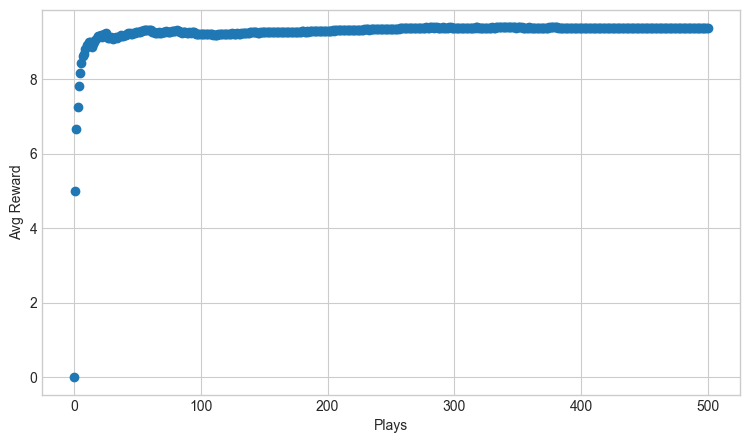

In [20]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel("Plays")
ax.set_ylabel("Avg Reward")
fig.set_size_inches(9,5)
rewards = [0]
for i in range(500):
    p = softmax(record[:,1],tau=0.7)
    choice = np.random.choice(np.arange(n),p=p)
    r = get_reward(probs[choice])
    record = update_record(record,choice,r)
    mean_reward = ((i+1) * rewards[-1] + r)/(i+2)
    rewards.append(mean_reward)
ax.scatter(np.arange(len(rewards)),rewards)

### 2.3 슬롯머신 예제를 광고 배치 최적화에 적용

광고 배치 최적화 : 사용자가 웹사이트의 광고를 클릭할 확률이 최대화되도록 광고를 선택하는 것   

예를 들어 컴퓨터, 신발, 장신구와 같은 다른 범주의 소매품을 파는 사이트 10개를 운영한다고 하자.   
전체 판매 촉진을 위해, 한 사이트에 접속한 고객에게 그 고객이 관심을 둘만한 다른 범주의 상품을 파는 다른 사이트 광고를 배치하고자 한다.   
또는 현재 사이트에서 파는 다른 상품 광고를 배치할 수도 있다.   

무작위보다는 효과적일 것이다.

### 2.4 파이토치로 신경망 만들기

### 2.5 문맥적 강도 문제의 해법

- 이제 알고리즘을 위한 시뮬레이션 환경을 살펴보자.  
- 10가지 쇼핑몰 사이트에 대응하는 0~9까지의 상태와 보상(광고 클릭), 그리고 10가지 중 하나를 선택하는 action으로 되어 있다.

In [21]:
class ContextBandit:
    def __init__(self, arms = 10):
        self.arms = arms
        self.init_distribution(arms)
        self.update_state()
        
    def init_distribution(self, arms):
        self.bandit_matrix = np.random.rand(arms, arms) # row: state, column 레버(액션)
        
    def reward(self, prob):
        reward = 0
        for i in range(self.arms):
            if random.random() < prob:
                reward += 1
        return reward
    
    def get_state(self):
        return self.state
    
    def update_state(self):
        self.state = np.random.randint(0,self.arms)
        
    def get_reward(self,arm):
        return self.reward(self.bandit_matrix[self.get_state()][arm])
        
    def choose_arm(self, arm): # 선택된 레버에 대한 리워드를 구하고 상태를 업데이트 한다.(다음 상태)
        reward = self.get_reward(arm)
        self.update_state()
        return reward

In [22]:
env = ContextBandit(arms = 10)
state = env.get_state()
reward = env.choose_arm(1)

In [23]:
print(state)
print(reward)

9
10


- 여기서는 단순함을 위해 상태 공간과 액션 공간이 같도록 했지만 상태공간이 훨씬 클 때가 많다.  